## GARCH MODELLING Example

In [111]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model # ARCH Package for Volatility Modeling
import plotly.graph_objs as go


import eikon as ek  # the Eikon Python wrapper package
import numpy as np  # NumPy
import pandas as pd  # pandas
import cufflinks as cf  # Cufflinks

ek.set_app_key('0999f7ba5a704212ad4e1f382863870c4615e33e')

st = '2020-04-01'  # start date
en= '2023-03-31'  # end date
### Getting Timeseries for a security.
df = ek.get_timeseries(['IN10YT=RR'],  # the RICs
                         fields='CLOSE',  # close field
                         start_date=st,  # start date
                         end_date=en)  # end date
miss_count = df['CLOSE'].isna().sum()
# print(miss_count)
df = df.dropna()

# Calculate Returns # Apply np.log() to the DataFrame
stock_returns = np.log(df).diff().mul(100)
stock_returns = stock_returns.dropna()
stock_returns['CLOSE'] = stock_returns['CLOSE'].astype(float) # Needed to convert object to float


# Fit GARCH(1, 1) model
model = arch_model(stock_returns, vol='GARCH', p=1, q=2)
garch_results = model.fit()

# Print model summary
print(garch_results.summary())

# Get conditional standard deviation
cond_std = garch_results.conditional_volatility

# Print the conditional standard deviation
#print(cond_std)

standardized_returns = stock_returns['CLOSE']/cond_std


fig = go.Figure()
fig.add_trace(go.Scatter(x=standardized_returns.index, y=standardized_returns, name='STANDARDIZED RETURNS'))
fig.add_trace(go.Scatter(x=stock_returns.index, y=stock_returns['CLOSE'], name='RETURNS'))

fig.show()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8067.1167701101585
Iteration:      2,   Func. Count:     17,   Neg. LLF: 364957266348.87476
Iteration:      3,   Func. Count:     27,   Neg. LLF: 786.5189153389617
Iteration:      4,   Func. Count:     36,   Neg. LLF: 693.9900851106642
Iteration:      5,   Func. Count:     44,   Neg. LLF: 598.8504749550962
Iteration:      6,   Func. Count:     51,   Neg. LLF: 597.7385047718711
Iteration:      7,   Func. Count:     57,   Neg. LLF: 597.5537487200103
Iteration:      8,   Func. Count:     63,   Neg. LLF: 597.5065460185986
Iteration:      9,   Func. Count:     69,   Neg. LLF: 597.505253503942
Iteration:     10,   Func. Count:     75,   Neg. LLF: 597.504923818753
Iteration:     11,   Func. Count:     80,   Neg. LLF: 597.5049238445172
Optimization terminated successfully    (Exit mode 0)
            Current function value: 597.504923818753
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


## 

[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return'], dtype='object')
╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.11         │         18.83          │         65.22         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛
**** GARCH MODEL PARAMS ***
mu          0.252721
omega       0.902331
alpha[1]    0.071748
beta[1]     0.873923
Name: params, dtype: float64


                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2022-10-13  14.218493  14.348346  14.471145  14.587273  14.697091


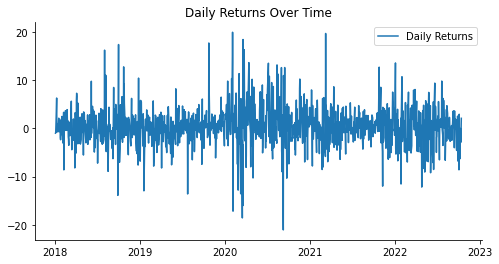

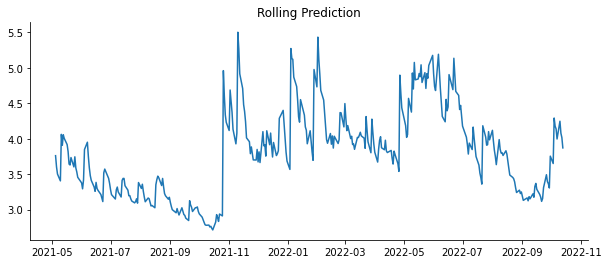

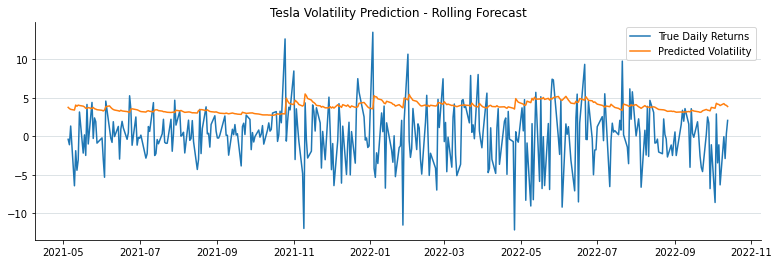

In [43]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ticker= "tsla"
stock_data = yf.download(ticker, start="2018-01-01", end="2022-10-14")
#print(tsla_data)
stock_data['Return'] = 100*(stock_data['Close'].pct_change())

print(tsla_data.columns)
stock_data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(stock_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

daily_volatility = stock_data['Return'].std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],
               headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],
               tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

# BUILD GARCH MODEL 
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(stock_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print('**** GARCH MODEL PARAMS ***')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

# ROLLING PREDICTIONS TO TEST MODEL FIT

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = stock_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=stock_data['Return'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

# VISUALIZE PREDICTIONS
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(stock_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])


In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model # ARCH Package for Volatility Modeling
import plotly.graph_objs as go


# Create a dataframe by reading epu data
df_epu = pd.read_excel('/Users/kalyan/Library/CloudStorage/OneDrive-IIMVIZAG/Kalyan-Research/T20-PolicyBrief-G20/Data/G20.xlsx'
                  , sheet_name='G20-EPU',
                   dtype={'Year':object,'Month':object,},
                      header=0);

#Uniformity in Year data - Convert Numeric to String
df_epu['Year'] = df_epu['Year'].astype(str)
#Uniformity in Month data - Convert Numeric to String of length 2
df_epu['Month'] = df_epu['Month'].astype(str).str.zfill(2)
#Generate Date in datetime dtype
df_epu['Date']= str('01')+df_epu['Month']+df_epu['Year']


df_epu['Date'] = pd.to_datetime(df_epu['Date'], 
                                 format='%d%m%Y')
df_epu['Year'] = pd.to_datetime(df_epu['Date'], 
                                 format='%Y')
df_epu['Month'] = pd.to_datetime(df_epu['Date'], 
                                 format='%m')

df_epu= df_epu.set_index('Date')

df_epu = df_epu.drop(columns=['Year', 'Month'])

# country_list = list(df_epu.columns)
# country_list = [e for e in country_list if e not in ('SCMP China', 'Mainland China')]
country_list = ['India']
# 'Japan', 'Germany', 'South Korea', 'France', 'Italy','Russia','SCMP China', 'Mainland China' , 'China']



df_epu = df_epu.dropna()

# Calculate Returns # Apply np.log() to the DataFrame
epu_returns['india_epu'] = df_epu[country_list]
print(epu_returns.columns)

epu_returns['epu_returns'] = np.log(epu_returns['india_epu']).diff().mul(100)
epu_returns = epu_returns.dropna()
epu_returns['epu_returns'] = epu_returns['epu_returns'].astype(float) # Needed to convert object to float


# Fit GARCH(1, 1) model
model = arch_model(epu_returns['epu_returns'], vol='GARCH', p=1, q=1)
garch_results = model.fit()

# Print model summary
print(garch_results.summary())

# Get conditional standard deviation
cond_std = garch_results.conditional_volatility

# Print the conditional standard deviation
#print(cond_std)

epu_returns['std_epu_returns'] = epu_returns['epu_returns']/cond_std

print(epu_returns.columns)

fig = go.Figure()
fig.add_trace(go.Scatter(x=epu_returns.index, y=epu_returns['std_epu_returns'], 
                         name='STD.EPU = EPU Returns/GARCH(1,1)'))
fig.add_trace(go.Scatter(x=epu_returns.index, y=epu_returns['epu_returns'], 
                         name='EPU returns'))
fig.add_trace(go.Scatter(x=epu_returns.index, y=epu_returns['india_epu'], 
                         name='EPU Index'))

# fed Tapering plan announced
fig.add_vline(x=pd.to_datetime("01062013",format='%d%m%Y'), line_width=1.25, line_dash="dash", line_color="Black")
fig.add_annotation(
    x=pd.to_datetime("01062013",format='%d%m%Y')
    , y=100+1
    , text=f'US Fed <br> Tapering <br> announcement <br> 2013'
    , yanchor='bottom'
    , showarrow=True
    , arrowhead=1
    , arrowsize=1
    , arrowwidth=2
    , arrowcolor="#636363"
    , ax=-20
    , ay=10
    , font=dict(size=8, color="Black", family="Courier New, monospace")
    , align="left"
    ,)

# Lehmann Collapse
fig.add_vline(x=pd.to_datetime("15092008",format='%d%m%Y'), line_width=1.25, line_dash="dash", line_color="Black")
fig.add_annotation(
    x=pd.to_datetime("15092008",format='%d%m%Y')
    , y=100+1
    , text=f'Lehmann Bank <br> Collapses <br> 2008'
    , yanchor='bottom'
    , showarrow=True
    , arrowhead=1
    , arrowsize=1
    , arrowwidth=2
    , arrowcolor="#636363"
    , ax=-20
    , ay=10
    , font=dict(size=8, color="Black", family="Courier New, monospace")
    , align="left"
    ,)

# Brexit Referendum Vote 23 June 2016
fig.add_vline(x=pd.to_datetime("23062016",format='%d%m%Y'), line_width=1.25, line_dash="dash", line_color="Black")
fig.add_annotation(
    x=pd.to_datetime("23062016",format='%d%m%Y')
    , y=100+1
    , text=f'Brexit Referendum <br> 2016'
    , yanchor='bottom'
    , showarrow=True
    , arrowhead=1
    , arrowsize=1
    , arrowwidth=2
    , arrowcolor="#636363"
    , ax=-20
    , ay=50
    , font=dict(size=8, color="Black", family="Courier New, monospace")
    , align="left"
    ,)

fig.show()

print(epu_returns.columns)
######### Write DataFrame to an external file #########
epu_returns.to_excel('/Users/kalyan/Documents/Kalyan-Research/EPU-Inv/epu-rawdata/epu_index/EPU-returns-built.xlsx', sheet_name='epu_returns', index=True)



Index(['India', 'india_epu', 'epu_returns', 'std_epu_returns'], dtype='object')
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1731.5279633974055
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1480.954171895803
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1477.7734488579229
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1477.7713895221689
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1477.771282094895
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1477.7706943739117
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1477.7677524856554
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1477.7534396315484
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1477.6909422627493
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1477.5321674095965
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1477.5027147980663
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1477.5002601926349
Iteration:     13,   Func. Count:     70,   Ne

Index(['India', 'india_epu', 'epu_returns', 'std_epu_returns'], dtype='object')
